# SD701 Lab session: classification and clustering

The goal of this lab session is for you to get a good grasp of data cleaning, clustering, classification implementations and evaluations. For this reason, the lab is less focused on re-implementing existing algorithms, and more onto using what is already available and making sense of it.

Let us make our imports.

In [1]:
import sklearn as sk
import numpy as np
from sklearn import cluster
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
import math
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
import scipy
import plotly.express as px
from sklearn.cluster import DBSCAN

## The Palmer Penguin dataset

Let us look at the [Palmer penguins]() dataset. It is a small dataset that contains measurements about real-world penguins.

Our task is to:

   - Do an exploratory analysis of the data
   - Think about what algorithms and features we want to use, and how we need to transform our variables
   - Run our algorithms and evaluate them

In [2]:
penguins_cs = pd.read_csv(open("data/penguins_size.csv"))

## Exploratory analysis

In [3]:
penguins_cs

species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen              39.1             18.7              181.0   
1    Adelie  Torgersen              39.5             17.4              186.0   
2    Adelie  Torgersen              40.3             18.0              195.0   
3    Adelie  Torgersen               NaN              NaN                NaN   
4    Adelie  Torgersen              36.7             19.3              193.0   
..      ...        ...               ...              ...                ...   
339  Gentoo     Biscoe               NaN              NaN                NaN   
340  Gentoo     Biscoe              46.8             14.3              215.0   
341  Gentoo     Biscoe              50.4             15.7              222.0   
342  Gentoo     Biscoe              45.2             14.8              212.0   
343  Gentoo     Biscoe              49.9             16.1              213.0   

     body_mass_g     sex  
0         3750.0    MALE  
1         3800.0  FEMALE  
2         3250.0  FEMALE  
3            NaN     NaN  
4         3450.0  FEMALE  
..           ...     ...  
339          NaN     NaN  
340       4850.0  FEMALE  
341       5750.0    MALE  
342       5200.0  FEMALE  
343       5400.0    MALE  

[344 rows x 7 columns]

- NaN Values

The first thing we can notice in the dataframe is that it contains some NaN values. Let's see how many there are:

In [4]:
penguins_cs.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [5]:
penguins_cs.dtypes

species               object
island                object
culmen_length_mm     float64
culmen_depth_mm      float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

- Distribution and correlation

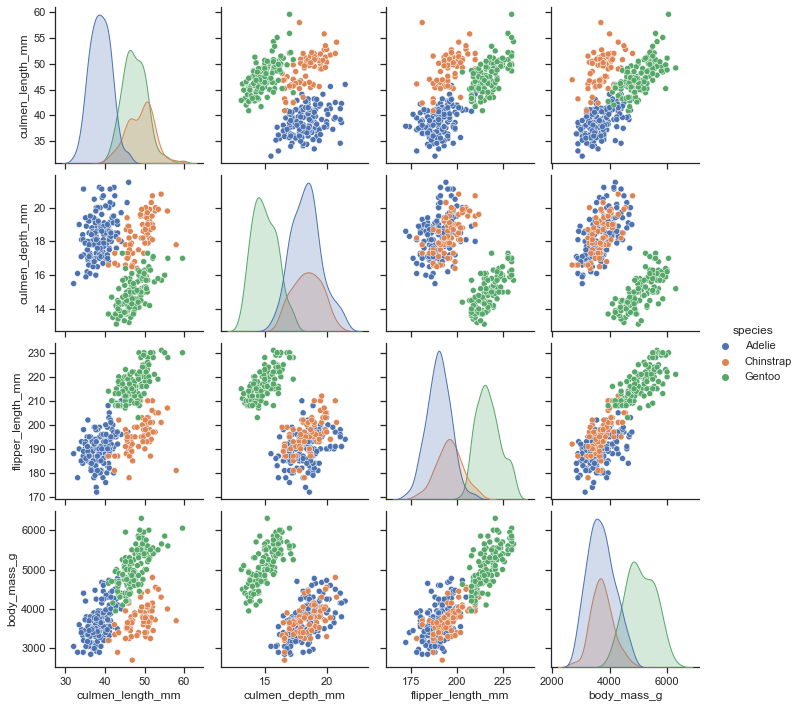

In [6]:
sns.set_theme(style="ticks")

#df = sns.load_dataset("penguins_cs")
sns.pairplot(penguins_cs, hue="species")

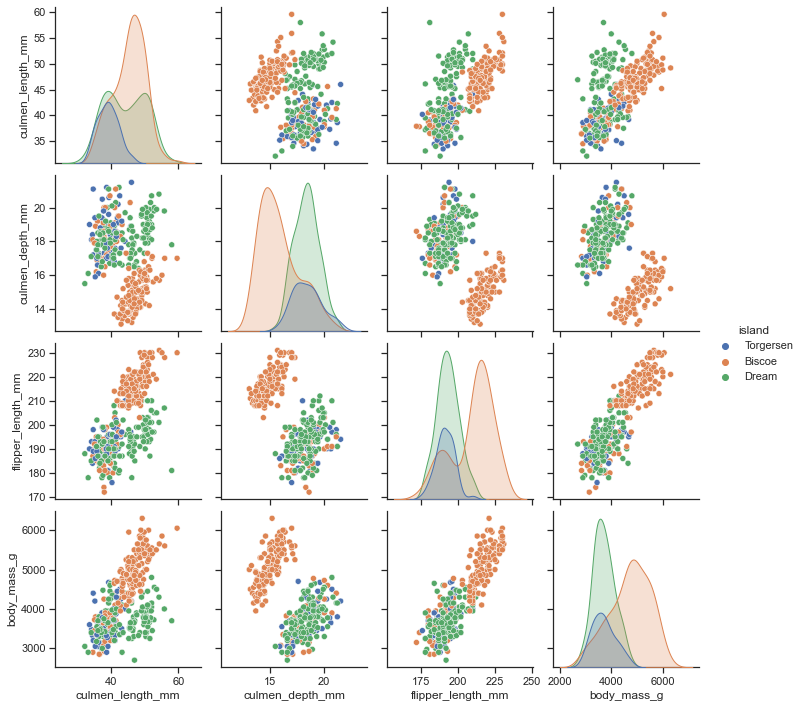

In [7]:
sns.pairplot(penguins_cs, hue="island")

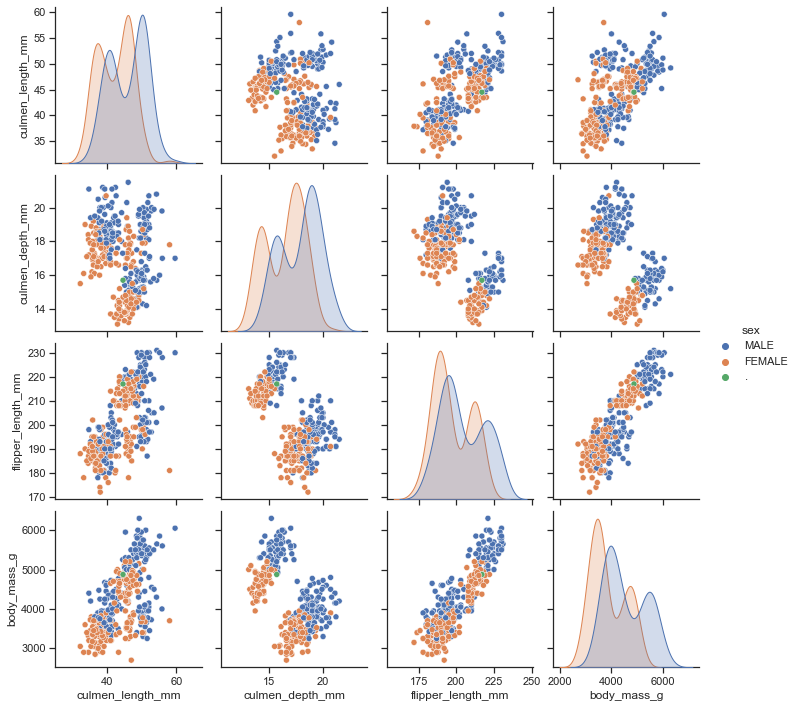

In [8]:
sns.pairplot(penguins_cs, hue="sex")

From these plots we see that our variables are neither standardized nor normalized and there are no correlation between them.

- Repartition of categorical variables

In [9]:
penguins_cs['species'].value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

We can see that the Chinstrap specy is less represented

In [10]:
penguins_cs['island'].value_counts()

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

We can see that the Torgersen island is less represented

In [11]:
penguins_cs['sex'].value_counts()

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64

We can see that 'sex' variable is well repartited but there is one outlier data making an other category 

## Learning on our dataset


As you can see, this data is not readily adapted for clustering: many of the variables are non-numerical. We could try different strategies:

   - Getting rid of all non numerical variables
   - Converting categorical variables to a [one-hot vector](https://en.wikipedia.org/wiki/One-hot) to use them
   
We will try both approaches. Below is the code for the first approach, the second is yours to write. You can also update the first approach to fill n/a values with something better than $0$.

### First approch : Getting rid of all non numerical variables

### Clustering

The first thing we can do is to replace NaN values from numeric variables with the mean value of their specy

In [12]:
penguins_cs['culmen_length_mm'] = penguins_cs['culmen_length_mm'].fillna(penguins_cs.groupby('species')['culmen_length_mm'].transform('mean'))
penguins_cs['culmen_depth_mm'] = penguins_cs['culmen_depth_mm'].fillna(penguins_cs.groupby('species')['culmen_depth_mm'].transform('mean'))
penguins_cs['flipper_length_mm'] = penguins_cs['flipper_length_mm'].fillna(penguins_cs.groupby('species')['flipper_length_mm'].transform('mean'))
penguins_cs['body_mass_g'] = penguins_cs['body_mass_g'].fillna(penguins_cs.groupby('species')['body_mass_g'].transform('mean'))

- Create a new DataFrame with numeric variables only

In [13]:
penguins_num=penguins_cs.copy()
penguins_num=penguins_num.select_dtypes(exclude=['object']) #exclude categorical features

In [14]:
penguins_num.head()

culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
0         39.100000        18.700000         181.000000  3750.000000
1         39.500000        17.400000         186.000000  3800.000000
2         40.300000        18.000000         195.000000  3250.000000
3         38.791391        18.346358         189.953642  3700.662252
4         36.700000        19.300000         193.000000  3450.000000

#### $k$-means

Let us focus on the $k$-means clustering algorithm. Once trained, the labels (_i.e._ the cluster assignation) is in `kmeans_algo.labels_`, and the centroids are in `kmeans_algo.cluster_centers_`.

Plot the data with colours for each cluster (in two dimensions).

For algorithms like k-means we need to normalize data because of the differences variances of the variables

In [15]:
penguins_num_norm = (penguins_num - penguins_num.min()) / (penguins_num.max() - penguins_num.min())
penguins_num_norm.head()

culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
0          0.254545         0.666667           0.152542     0.291667
1          0.269091         0.511905           0.237288     0.305556
2          0.298182         0.583333           0.389831     0.152778
3          0.243323         0.624566           0.304299     0.277962
4          0.167273         0.738095           0.355932     0.208333

In [16]:
def kmeans_cluster(df,kmeans_algo):
    cdict = {0: 'orange', 1: 'blue', 2: 'green'}
    cdict_marker={0:'yellow',1:'cyan',2:'lime'}
    for index, row in df.iterrows():
        plt.scatter(row['culmen_length_mm'], row['culmen_depth_mm'],color=cdict[kmeans_algo.labels_[index]])
    for i in range(0,len(kmeans_algo.cluster_centers_)):
        plt.scatter(kmeans_algo.cluster_centers_[i][0],kmeans_algo.cluster_centers_[i][1],c=cdict_marker[i],marker='x',label=f"centroide cluster {i}")
    plt.title('2D Penguins cluster')
    plt.xlabel('culmen_length_mm')
    plt.ylabel('culmen_depth_mm')
    plt.legend()
    plt.show()

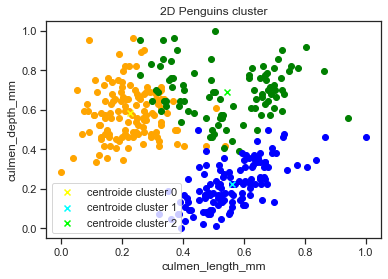

In [17]:
kmeans_algo = cluster.KMeans(n_clusters=3)
kmeans_results = kmeans_algo.fit_transform(penguins_num_norm)
kmeans_cluster(penguins_num_norm,kmeans_algo)

Above we fixed the number of clusters to 3 but we need to find the most appropriate value with the elbow method

**Finding the right $k$ with the elbow method**

Let us find the most appropriate value for $k$ using the "elbow" method. It consists in plotting, for multiple values of $k$, the global clustering score. While in theory the score can be anything you want, for today let us use the _distortion_. For a cluster $C$ with centroid $c$ and points $(x^{c}_i)_{i=0}$, its distortion $d(c)$ is the sum of the squared distances between the points and the centroid:

$$
    d(c) = \sum_i |x_i - c|^2,
$$

and the distortion of our $k$ clusters is the sum of distortions for each cluster. You can fill the list `elbow_scores` with the scores you will have computed.

In [18]:
def distortion(data, clustering):
    distortion = 0.0
    kmeans_algo = cluster.KMeans(n_clusters=clustering)
    kmeans_results = kmeans_algo.fit_transform(data)
    kmeans_labels=kmeans_algo.labels_
    
    for index, row in data.iterrows():
        cal=np.arange(0,len(data.columns)) #to loop on features x
        cal=(abs(row[cal]-kmeans_algo.cluster_centers_[kmeans_labels[index]][cal]))**2
        distortion+=np.sum(cal)
    return distortion 

def elbow_methode(df,min_k=1,max_k=10):
    elbow_scores = []
    for k in range(min_k,max_k+1):
        k_distortion=distortion(df,k)
        elbow_scores.append(k_distortion)
    plt.plot(list(range(min_k, max_k+1)), elbow_scores)
    plt.xlabel("k")
    plt.title("K-means elbow method")
    plt.ylabel("Distortion");

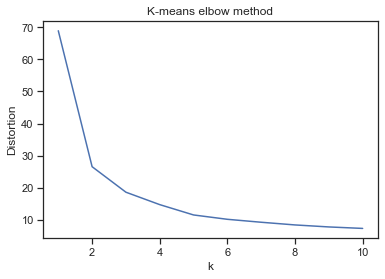

In [19]:
elbow_methode(penguins_num_norm)

As we can see with the elbow method the most better choice for k is 3

#### Classification

While we have not seen any classification algorithms in class yet, let us try to classify (instead of cluster) our data. The code for the classification algorithm is already completely written out for you, so you can focus on the other tasks.

Start by choosing what you want to classify on (for example, the species). You can use the exploratory data analysis you did before to guide your choice.

In [20]:
penguins_cs.isna().sum()

species               0
island                0
culmen_length_mm      0
culmen_depth_mm       0
flipper_length_mm     0
body_mass_g           0
sex                  10
dtype: int64

We can see that we have some missing values in "sex" category. The idea is to try to classifier the sex category in order to find these missing values

- Create train, test and validation datasets

In [21]:
penguins_validation=penguins_cs[(penguins_cs['sex']!="MALE") & (penguins_cs['sex']!="FEMALE")]
penguins_cs=penguins_cs.drop(penguins_cs.index[penguins_validation.index]) #remove validation values
penguins_validation

species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
3    Adelie  Torgersen         38.791391        18.346358         189.953642   
8    Adelie  Torgersen         34.100000        18.100000         193.000000   
9    Adelie  Torgersen         42.000000        20.200000         190.000000   
10   Adelie  Torgersen         37.800000        17.100000         186.000000   
11   Adelie  Torgersen         37.800000        17.300000         180.000000   
47   Adelie      Dream         37.500000        18.900000         179.000000   
246  Gentoo     Biscoe         44.500000        14.300000         216.000000   
286  Gentoo     Biscoe         46.200000        14.400000         214.000000   
324  Gentoo     Biscoe         47.300000        13.800000         216.000000   
336  Gentoo     Biscoe         44.500000        15.700000         217.000000   
339  Gentoo     Biscoe         47.504878        14.982114         217.186992   

     body_mass_g  sex  
3    3700.662252  NaN  
8    3475.000000  NaN  
9    4250.000000  NaN  
10   3300.000000  NaN  
11   3700.000000  NaN  
47   2975.000000  NaN  
246  4100.000000  NaN  
286  4650.000000  NaN  
324  4725.000000  NaN  
336  4875.000000    .  
339  5076.016260  NaN

In [22]:

def train_test_split(data: pd.DataFrame, target_key:str, percent_test: int =15):
    df_shuffle=shuffle(data)
    percentage=round(len(data)/100*percent_test) 
    
    test=df_shuffle.iloc[0:percentage-1]
    train=df_shuffle.iloc[percentage:]
    
    X_train=train.drop(target_key,axis=1)
    y_train=train[target_key]
    
    X_test=test.drop(target_key,axis=1)
    y_test=test[target_key]
    
    ##resample to equilibrate the labels in the train set
    sm = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
    
    return X_train_resampled, y_train_resampled, X_test, y_test

In [23]:
target="sex"
labelencoder = LabelEncoder()
penguins_cs[target]=labelencoder.fit_transform(penguins_cs[target]) #Label encoder for the target key
X_train, y_train, X_test, y_test = train_test_split(penguins_cs.drop(['species','island'],axis=1), target_key=target)

Check that your train and test set are appropriate. For example, is the repartition of the target variable similar? If not, how could you correct this issue?

I corrected it with an over sampling function (SMOTE) included in my train_test_split function

- Random Forest Algorithm

In [24]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

In [25]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9183673469387755


In [26]:
metrics.confusion_matrix(y_test, y_pred)

array([[23,  0],
       [ 4, 22]])

We have a pretty good accuracy with our model so now we can predit our validation dataset

In [27]:
y_pred_validation=rf.predict(penguins_validation.select_dtypes(exclude=['object']))
penguins_MissVal=penguins_validation.copy()
penguins_MissVal[target]=y_pred_validation
penguins_MissVal

species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
3    Adelie  Torgersen         38.791391        18.346358         189.953642   
8    Adelie  Torgersen         34.100000        18.100000         193.000000   
9    Adelie  Torgersen         42.000000        20.200000         190.000000   
10   Adelie  Torgersen         37.800000        17.100000         186.000000   
11   Adelie  Torgersen         37.800000        17.300000         180.000000   
47   Adelie      Dream         37.500000        18.900000         179.000000   
246  Gentoo     Biscoe         44.500000        14.300000         216.000000   
286  Gentoo     Biscoe         46.200000        14.400000         214.000000   
324  Gentoo     Biscoe         47.300000        13.800000         216.000000   
336  Gentoo     Biscoe         44.500000        15.700000         217.000000   
339  Gentoo     Biscoe         47.504878        14.982114         217.186992   

     body_mass_g  sex  
3    3700.662252    0  
8    3475.000000    0  
9    4250.000000    1  
10   3300.000000    0  
11   3700.000000    0  
47   2975.000000    0  
246  4100.000000    0  
286  4650.000000    0  
324  4725.000000    0  
336  4875.000000    0  
339  5076.016260    1

- Create a clean DataFrame 

In [28]:
df_penguins=pd.concat([penguins_cs,penguins_MissVal]).sort_index()

In [29]:
df_penguins.head()

species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen         39.100000        18.700000         181.000000   
1  Adelie  Torgersen         39.500000        17.400000         186.000000   
2  Adelie  Torgersen         40.300000        18.000000         195.000000   
3  Adelie  Torgersen         38.791391        18.346358         189.953642   
4  Adelie  Torgersen         36.700000        19.300000         193.000000   

   body_mass_g  sex  
0  3750.000000    1  
1  3800.000000    0  
2  3250.000000    0  
3  3700.662252    0  
4  3450.000000    0

In [30]:
df_penguins.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

We have no more NaN values in our Dataframe

### Second approch :  use categorical variables

We can start with "df_penguins" dataframe just above which is a clean dataframe 

K-means algorithm is not suitable for clustering categorical variable. So let's continue to classification.

### Classification

Here we converte categorical variables to a one-hot vector to use them

- #### Species classification

In [31]:
target_1="species"
penguins_cat=df_penguins.copy()
ohe_island=pd.get_dummies(penguins_cat.island,drop_first = True)# one-hot encoding and drop redundant information
penguins_cat=penguins_cat.drop(["island"],axis=1)
penguins_cat=penguins_cat.join(ohe_island)
penguins_cat_pred=penguins_cat.copy()
penguins_cat_pred.head()

species  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
0  Adelie         39.100000        18.700000         181.000000  3750.000000   
1  Adelie         39.500000        17.400000         186.000000  3800.000000   
2  Adelie         40.300000        18.000000         195.000000  3250.000000   
3  Adelie         38.791391        18.346358         189.953642  3700.662252   
4  Adelie         36.700000        19.300000         193.000000  3450.000000   

   sex  Dream  Torgersen  
0    1      0          1  
1    0      0          1  
2    0      0          1  
3    0      0          1  
4    0      0          1

In [32]:
X_train_1, y_train_1, X_test_1, y_test_1 = train_test_split(penguins_cat_pred, target_key=target_1)

In [33]:
#Label binarize
y_classes_1=list(y_train_1.unique())
y_train_1= label_binarize(y_train_1, classes=y_classes_1)
y_test_1= label_binarize(y_test_1, classes=y_classes_1)

In [34]:
# Simple random forest code
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train_1, y_train_1)
y_pred_1=rf.predict(X_test_1)

In [35]:
print(f"{target_1} accuracy: {metrics.accuracy_score(y_test_1, y_pred_1)}")

species accuracy: 1.0


- #### Island classification

In [36]:
target_2="island"
penguins_cat=df_penguins.copy()
ohe_species=pd.get_dummies(penguins_cat.species,drop_first = True)# one-hot encoding and drop redundant information
penguins_cat=penguins_cat.drop(["species"],axis=1)
penguins_cat=penguins_cat.join(ohe_species)
penguins_cat_pred=penguins_cat.copy()
penguins_cat_pred.head()

island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Torgersen         39.100000        18.700000         181.000000   
1  Torgersen         39.500000        17.400000         186.000000   
2  Torgersen         40.300000        18.000000         195.000000   
3  Torgersen         38.791391        18.346358         189.953642   
4  Torgersen         36.700000        19.300000         193.000000   

   body_mass_g  sex  Chinstrap  Gentoo  
0  3750.000000    1          0       0  
1  3800.000000    0          0       0  
2  3250.000000    0          0       0  
3  3700.662252    0          0       0  
4  3450.000000    0          0       0

In [37]:
X_train_2, y_train_2, X_test_2, y_test_2 = train_test_split(penguins_cat_pred, target_key=target_2)

In [38]:
#Label binarize
y_classes_2=list(y_train_2.unique())
y_train_2= label_binarize(y_train_2, classes=y_classes_2)
y_test_2= label_binarize(y_test_2, classes=y_classes_2)

In [39]:
# Simple random forest code
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train_2, y_train_2)
y_pred_2=rf.predict(X_test_2)

In [40]:
print(f"{target_2} accuracy: {metrics.accuracy_score(y_test_2, y_pred_2)}")

island accuracy: 0.5686274509803921


In [59]:
import re
a="--20"
temp3 = re.findall(r'\d+', a)
print(int(temp3[0]))

20


## Evaluation

Now it is time to focus on the evaluation of our models. Let us use this as an opportunity to compare the clustering and classification approaches.

   - How can we evaluate the quality of the clustering? Think about the ranking agreement metrics we saw in the first lecture
   - Can we look at the confusion matrix outputted by our classification algorithm?
   - How can we evaluate the quality of the classification? You can go read again about the F1-score and ROC curves

In [41]:

def Roc_plot(y_classes,y_test,y_pred,target):
    falsePos = {}
    truePos = {}
    roc_area = {}
    colors = ['orange', 'blue', 'lime']
    fig = go.Figure()
    for i in range(len(y_classes)):
        falsePos[i], truePos[i], _ = metrics.roc_curve(y_test[:, i], y_pred[:, i])
        roc_area[i] = metrics.auc(falsePos[i], truePos[i])
    for i, color in zip(range(len(y_classes)), colors):
        fig.add_trace(go.Scatter(x=falsePos[i], y=truePos[i], name=f'ROC of class {y_classes[i]} (area = {round(roc_area[i],2)})', mode='lines'))
        
    fig.add_shape(x0=0, x1=1, y0=0, y1=1,type='line', line=dict(dash='dash'))
    
    fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    title=f'ROC curves for {target} predictions'
    )
    fig.show()

In [42]:
def conf_matrix(y_test,y_pred,y_class,target):
    conf_matrix=metrics.confusion_matrix(y_test, y_pred)
    conf_matrix=conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(conf_matrix, annot=True,
                cmap="Blues", linewidths=0.2)

    # Add labels to the plot

    tick_marks = np.arange(len(y_class))
    plt.xticks(tick_marks+0.5, y_class)
    plt.yticks(tick_marks+0.5, y_class)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {target} prediction')
    plt.show()

- Species Model

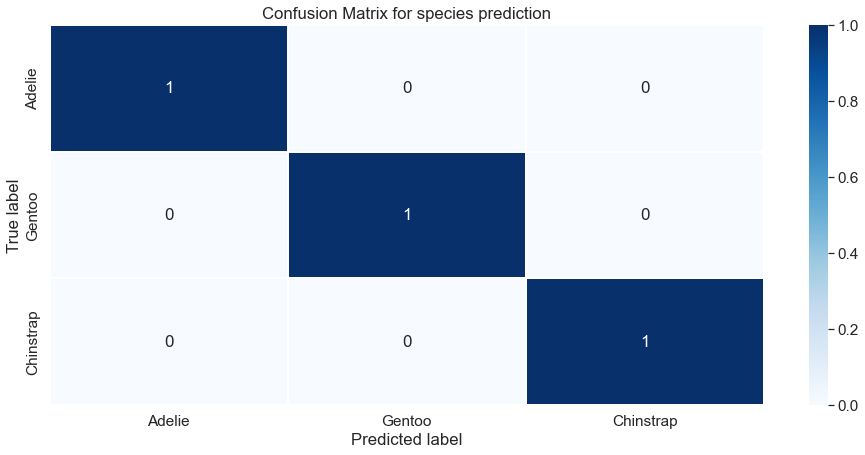

In [43]:
# Confusion matrix 
conf_matrix(y_test_1.argmax(axis=1), y_pred_1.argmax(axis=1),y_classes_1,target_1)

In [44]:
# View the classification report 
print(metrics.classification_report(y_test_1, y_pred_1,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        11

   micro avg       1.00      1.00      1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51
 samples avg       1.00      1.00      1.00        51



In [45]:
Roc_plot(y_classes_1,y_test_1,y_pred_1,target_1)

If we look at the three evaluation models above, we can see that the model predict well the pengouins species

- Island Model

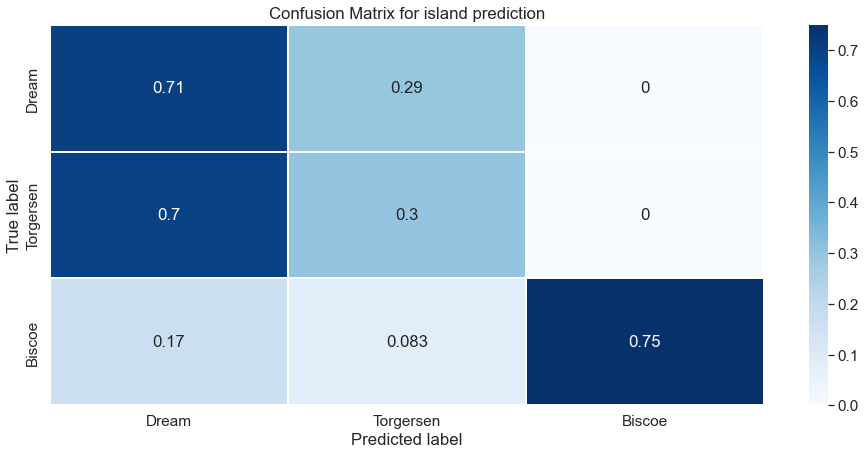

In [46]:
# Confusion matrix for test and predictions
conf_matrix(y_test_2.argmax(axis=1), y_pred_2.argmax(axis=1),y_classes_2,target_2)

In [47]:
# View the classification report for test data and predictions
print(metrics.classification_report(y_test_2, y_pred_2,zero_division=0))

              precision    recall  f1-score   support

           0       0.80      0.47      0.59        17
           1       0.30      0.30      0.30        10
           2       1.00      0.75      0.86        24

   micro avg       0.76      0.57      0.65        51
   macro avg       0.70      0.51      0.58        51
weighted avg       0.80      0.57      0.66        51
 samples avg       0.57      0.57      0.57        51



In [48]:
Roc_plot(y_classes_2,y_test_2,y_pred_2,target_2)

We can see from the three evalutions above that it is more difficult for the model to predict the pengouins island especially for the Torgersen and Dream classes which can be explain by their similar distribution we saw in exploratory analysis pairplots.

## Implementing DBScan

For the last part of the lab, let us focus a little bit on implementation. Your goal is to reimplement a functional version of the [DBScan algorithm]() that we saw during the lecture. You will find below a skeleton of code that you can fill in.

Once you have a functional version (if you still have time), you can try to make your implementation faster, by thinking about the following questions:

   - Can the neighbourhood lookup be faster?
   - Can the $\mu$ parameter be implemented easily?
   - How can the scalability of the algorithm be tested?

As for k-means, DBSCAN only works for normalized numerical variables.
Here we will reuse the penguins_num_norm dataframe.

In [49]:
penguins_num_norm.head()

culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
0          0.254545         0.666667           0.152542     0.291667
1          0.269091         0.511905           0.237288     0.305556
2          0.298182         0.583333           0.389831     0.152778
3          0.243323         0.624566           0.304299     0.277962
4          0.167273         0.738095           0.355932     0.208333

In [50]:

def dbscan(data:pd.DataFrame,epsilon:float,mu:int=1):
    n=data.shape[0]
    cluster=np.zeros(n,int)
    visited=np.zeros(n,int)
    dist_matrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(data, 'euclidean'))
    cluster_Nb=0
    for i in data.index:
        if visited[i]==0:
            visited[i]=1
            neighbors_list=np.where(dist_matrix[i]<=epsilon)[0]
            if len(neighbors_list)>=mu:
                cluster[i]=cluster_Nb
                index=0
                while index != len(neighbors_list):
                    j=neighbors_list[index]
                    if visited[j]==0:
                        visited[j]=1
                    new_neighbors=np.where(dist_matrix[j]<=epsilon)[0]
                    for k in new_neighbors:
                                if k not in neighbors_list:
                                    neighbors_list=np.append(neighbors_list,k)
                    cluster[j]=cluster_Nb
                    index+=1
                cluster_Nb+=1
            else:
                cluster[i]=-1
    return cluster
            

- Determine dbscan parameters epsilon & min_samples

In the following part, the min_sample value is fixed to 2 times the number of variables. For epsilon, we iterate in order to find the value where 95% of the points belonging to a cluster

In [51]:
nb_cluster_points=[]
epsilons=np.arange(0, 1, 0.01)
for epsilon in epsilons:
    l=dbscan(penguins_num_norm,epsilon,2*penguins_num_norm.shape[1])
    nb_cluster_points.append(penguins_num_norm.shape[0]-((l == -1).sum()))

optimal_epsilon=[n for n,i in enumerate(nb_cluster_points) if i>=0.95*penguins_num_norm.shape[0]][0]


fig = go.Figure()
fig.add_trace(go.Scatter(x=epsilons, y=nb_cluster_points, mode='lines',name="Number of points belonging to a cluster "))
fig.add_trace(go.Scatter(x=[0,max(epsilons)], 
                         y=[0.95*penguins_num_norm.shape[0],0.95*penguins_num_norm.shape[0]], 
                         mode='lines', 
                         line=dict(color='red', dash='dash'),
                         name='95% of points included in a cluster'))

fig.update_layout(
    title='Number of points belonging to a cluster based on Epsilon',
    xaxis_title='Epsilon',
    yaxis_title='Number of points in a cluster')

fig.show()

- Use dbscan algorithm with the epsilons found

In [52]:
dbscan_cluster=dbscan(penguins_num_norm,epsilons[optimal_epsilon],2*penguins_num_norm.shape[1])
dbscan_cluster

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  1,
        1,  1,  1,  1,  1

In [53]:
fig = px.scatter(penguins_num_norm, x="culmen_length_mm", y="culmen_depth_mm", color=[str(i) for i in dbscan_cluster],title="DBSCAN clusters in two dimensions")
fig.show()

- Comparison with sklearn DBSCAN with the same parameters

In [54]:
clustering = DBSCAN(eps=epsilons[optimal_epsilon], min_samples=2*penguins_num_norm.shape[1],metric='euclidean').fit(penguins_num_norm)
clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  1,
        1,  1,  1,  1,  1

In [55]:
fig = px.scatter(penguins_num_norm, x="culmen_length_mm", y="culmen_depth_mm", color=[str(i) for i in clustering.labels_],title="Sklearn DBSCAN clusters in two dimensions")
fig.show()

In [56]:
print(f"For the same epsilon, the number of points not clustered in my algorithm is {( dbscan_cluster== -1).sum()} and {(clustering.labels_ == -1).sum()} as comparison for the sklearn one")

For the same epsilon, the number of points not clustered in my algorithm is 12 and 22 as comparison for the sklearn one


My algorithm seems to work as a DBSCAN but I don't have the same results as with the sklearn version.